In [1]:
import lhapdf
#import ROOT
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from iminuit import Minuit
import sys
sys.path.insert(1,'DSS')
import fDSS_

4.0


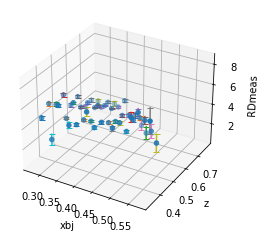

4.75


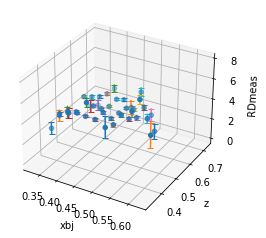

5.5


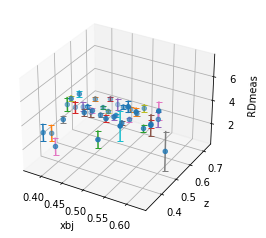

In [2]:
def Get_weighted_average(value,error):
    sum_mean = 0
    sum_sigma = 0
    for i in range(len(value)):
        sum_mean += value[i]/(error[i]*error[i])
        sum_sigma += 1/(error[i]*error[i])
    return sum_mean/sum_sigma
def Get_weighted_sigma(value,error):
    sum_sigma = 0
    for i in range(len(value)):
        sum_sigma += 1/(error[i]*error[i])
    return math.sqrt(1/sum_sigma)

with open('yield_ratio_xz_combined_weighted.json') as j_RD:
    RDxz = json.load(j_RD)
#with open('yield_ratio_Q2xzRunG_combined.json') as j_RD:
#    RDxz = json.load(j_RD)
for key_Q2,Q2_value in RDxz.items():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    zs = []
    xs = []
    RDs = []
    RDs_error = []
    Q2 = float(key_Q2)
    print(Q2)
    for key_xbj,xbj_value in Q2_value.items():
        xbj = float(key_xbj) 
        for key_z,z_value in xbj_value.items():
            xs.append(xbj)
            z_hadron = float(key_z)
            zs.append(z_hadron)
            RD=float(z_value["value_ratio"])
            RD_error = float(z_value["error_ratio"])
            RDs.append(float(z_value["value_ratio"]))
            RDs_error.append(float(z_value["error_ratio"]))
            ax.plot([xbj,xbj],[z_hadron,z_hadron],[RD+RD_error,RD-RD_error],marker="_")
    ax.scatter(xs,zs,RDs)
    ax.set_xlabel("xbj")
    ax.set_ylabel("z")
    ax.set_zlabel("RDmeas")
    plt.show()

LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
4.0
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
4.75
5.5


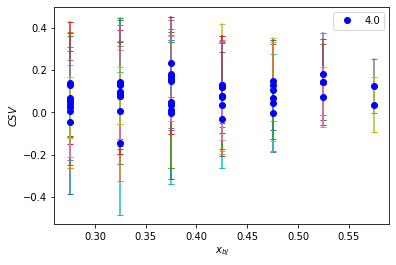

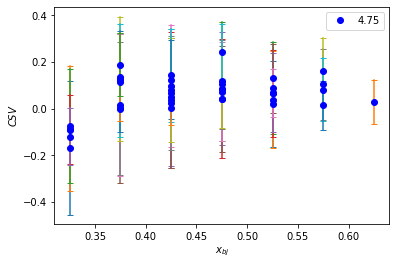

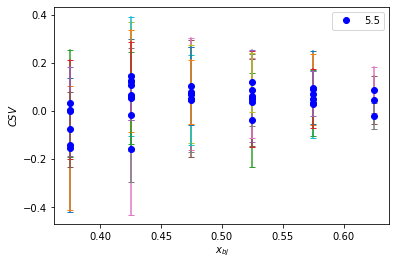

In [4]:
## Getting a PDF member object

p_cteq6 = lhapdf.mkPDF("cteq6l1", 0)
p_cteq6 = lhapdf.mkPDF("cteq6l1/0")
def Ax(Q,xbj):
    return -4/(3*(p_cteq6.xfxQ(2,xbj,Q)+p_cteq6.xfxQ(1,xbj,Q)))
def Bx(Q,xbj):
    return  2.5+5*(p_cteq6.xfxQ(-2,xbj,Q)+p_cteq6.xfxQ(-1,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    
def Get_D_fav(Q,z_had):
    """
    #Kretzer
    Dd_plus = 0.217*z_had**-1.805*(1-z_had)**2.037
    D_fav = Dd_plus;
    """
    #Binneweis
    Lambda = 0.227
    sv = math.log(math.log(Q*Q/(Lambda**2))/math.log(2/Lambda**2))
    N = 1.150-1.522*sv+1.378*sv**2-0.527*sv**3
    a1 = -0.740-1.680*sv+1.546*sv**2-0.596*sv**3
    a2 = 1.430+0.543*sv-0.023*sv**2
    D_sum = N*z_had**a1*(1.0-z_had)**a2
    #Ratio of D-/D+ from P.Geiger's thesis HERMES
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    D_fav = D_sum/(1.0+R_D)
    
    return D_fav
def Get_D_unfav(Q,z_had):
    """
    #Kretzer
    Du_plus = 0.689*z_had**-1.039*(1-z_had)**1.241
    D_unfav = Du_plus;
    """
    #Binneweis
    Lambda = 0.227
    sv = math.log(math.log(Q*Q/(Lambda**2))/math.log(2/Lambda**2))
    N = 1.150-1.522*sv+1.378*sv**2-0.527*sv**3
    a1 = -0.740-1.680*sv+1.546*sv**2-0.596*sv**3
    a2 = 1.430+0.543*sv-0.023*sv**2
    D_sum = N*z_had**a1*(1.0-z_had)**a2
    #Ratio of D-/D+ from P.Geiger's thesis HERMES
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    D_unfav = D_sum/(1.0+1.0/R_D)
    
    return D_unfav
def Dz(Q,z_had):
    '''
    #Kretzer
    Dd_plus = 0.217*z_had**-1.805*(1-z_had)**2.037
    Du_plus = 0.689*z_had**-1.039*(1-z_had)**1.241 
    delta_z = Dd_plus/Du_plus
    
    #P.Geiger's thesis
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    delta_z = R_D
    '''
    #fDSS
    duplus = fDSS_.fdss(1,1,0,z_hadron,Q*Q)[0]
    duminus = fDSS_.fdss(1,-1,0,z_hadron,Q*Q)[0]
    delta_z = duminus/duplus
    return (1-delta_z)/(1+delta_z)

def CSVx(Q,z_had,xbj,RDmeas):
    return (Bx(Q,xbj)-Dz(Q,z_had)*(RDmeas+2.5))/Ax(Q,xbj)
#def RDmeas_CSV(Q,z_had,xbj,CSV_1,CSV_2):
#    CSVx = (Bx-Dz*(RDmeas+2.5))/Ax
#    return (Bx-Ax*CSVx)/Dz-2.5


Qs = []
i_Q2 = 0
for key_Q2,Q2_value in RDxz.items():
    fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')
    zs = []
    xs = []
    RDs = []
    RDs_error = []
    CSVx_Q2 = []
    Q2 = float(key_Q2)
    Qs.append(Q2)
    print(Q2)
    for key_xbj,xbj_value in Q2_value.items():
        xbj = float(key_xbj) 
        CSVx_Q2x = []
        for key_z,z_value in xbj_value.items():
            xs.append(xbj)
            z_hadron = float(key_z)
            zs.append(z_hadron)
            RD=float(z_value["value_ratio"])
            RD_error = float(z_value["error_ratio"])
            RDs.append(float(z_value["value_ratio"]))
            RDs_error.append(float(z_value["error_ratio"]))
            #z_corr = float(z_value["z_corr"])*z_hadron
            #zs.append(z_corr)
            #xbj_corr = float(z_value["xbj_corr"])*xbj
            #xbj_corr_err = float(z_value["xbj_corr_err"])
            #xbj_corrs.append(xbj_corr)
            #xbj_corr_errs.append(xbj_corr_err)
            #CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
            CSVxi = xbj*CSVx(math.sqrt(Q2),z_hadron,xbj,RD)
            CSVx_Q2.append(CSVxi)
            #CSVxi_err = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD_error)
            CSVxi_err = xbj*CSVx(math.sqrt(Q2),z_hadron,xbj,RD_error)
            plt.plot([xbj,xbj],[CSVxi+CSVxi_err,CSVxi-CSVxi_err],marker="_")
            #plt.plot([xbj_corr,xbj_corr],[CSVxi+CSVxi_err,CSVxi-CSVxi_err],marker = "_")
    
    plt.plot(xs,CSVx_Q2,'bo',label = Qs[i_Q2])
    plt.xlabel(r'$x_{bj}$')
    plt.ylabel(r'$CSV$')
    plt.legend()
   
    i_Q2+=1

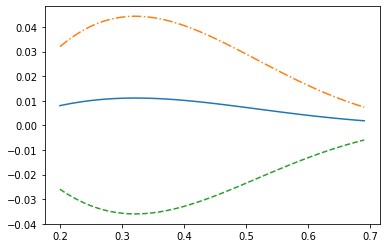

In [5]:
def delta_udv(parameter):
    x = np.arange(0.2,0.7,0.01)
    return x*parameter*(1-x)**4*x**-0.5*(x-0.0909)
x_axis = np.arange(0.2,0.7,0.01)
y_delta_uv = delta_udv(-0.2)
y_delta_dv = delta_udv(0.2)
y_delta_uv_up = delta_udv(0.8)
y_delta_uv_low = delta_udv(-0.8)
y_delta_dv_up = delta_udv(-0.65)
y_delta_dv_low = delta_udv(0.65)
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')

4.0
4.75
5.5


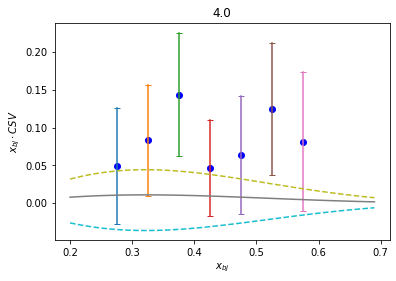

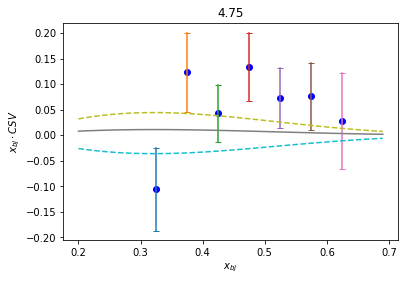

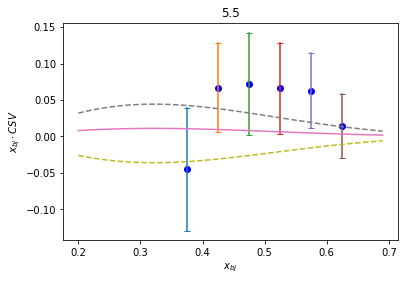

In [12]:


i_Q2 = 0
for key_Q2,Q2_value in RDxz.items():
    fig = plt.figure()
    ax = fig.add_subplot()
    #ax = fig.add_subplot(projection='3d')
    zs = []
    xs = []
    RDs = []
    RDs_error = []
    CSVx_Q2 = []
    Q2 = float(key_Q2)
    Qs.append(Q2)
    print(Q2)
    for key_xbj,xbj_value in Q2_value.items():
        xbj = float(key_xbj) 
        CSVx_Q2x = []
        CSVx_err_Q2x = []
        for key_z,z_value in xbj_value.items():
            xs.append(xbj)
            z_hadron = float(key_z)
            zs.append(z_hadron)
            RD=float(z_value["value_ratio"])
            RD_error = float(z_value["error_ratio"])
            RDs.append(float(z_value["value_ratio"]))
            RDs_error.append(float(z_value["error_ratio"]))
            CSVxi = xbj*CSVx(math.sqrt(Q2),z_hadron,xbj,RD)
            CSVx_Q2x.append(CSVxi)
            CSVxi_err = xbj*CSVx(math.sqrt(Q2),z_hadron,xbj,RD_error)
            CSVx_err_Q2x.append(CSVxi_err)
            #plt.plot([xbj,xbj],[CSVxi+CSVxi_err,CSVxi-CSVxi_err],marker="_")
        CSVx_mean = Get_weighted_average(CSVx_Q2x,CSVx_err_Q2x)
        CSVx_sigma = Get_weighted_sigma(CSVx_Q2x,CSVx_err_Q2x)
        plt.plot(xbj,CSVx_mean,'bo')
        plt.plot([xbj,xbj],[CSVx_mean+CSVx_sigma,CSVx_mean-CSVx_sigma],marker="_")
    plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
    plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'--')
    plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
    plt.xlabel(r"$x_{bj}$")
    plt.ylabel(r"$x_{bj} \cdot CSV$")
    #plt.ylim(-0.07,0.07)
    
    ax.set_title(Qs[i_Q2])
    i_Q2+=1
